In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

In [2]:
dataset = 'kitti'
annot_dir = './kitti/training_coco'
imgs_dir = './kitti/training_voc/VOC2012/JPEGImages'

for split in ['train', 'val']: 
    #if split == 'train':
        #annot_path = os.path.join(annot_dir, f'{split}_temp.json')
    #else:
    annot_path = os.path.join(annot_dir, f'{split}.json')
    d_name = dataset + f'_{split}'
    register_coco_instances(d_name, {}, annot_path, imgs_dir)

# Load dataset
dataset_dicts = DatasetCatalog.get('kitti_train')
metadata = MetadataCatalog.get('kitti_train')

[03/15 14:22:29 d2.data.datasets.coco]: Loaded 5984 images in COCO format from ./kitti/training_coco/train.json


In [3]:
import argparse

class Args(argparse.Namespace):
    config_file='khang_net/configs/yolof/yolof_resnet_50_1x.py'
    eval_only=False
    num_gpus=1
    num_machines=1
    resume=False

args = Args()

In [4]:
from detectron2.model_zoo import get_config
from detectron2.config import LazyConfig
from detectron2.config.instantiate import instantiate


cfg = LazyConfig.load("khang_net/configs/yolof/yolof_resnet_50_1x.py")
cfg.train.device = 'mps'
cfg.dataloader.evaluator.dataset_name = 'kitti_val'
cfg.dataloader.train.dataset.names = 'kitti_train'
cfg.dataloader.test.dataset.names = 'kitti_val'

cfg.dataloader.train.total_batch_size = 1
cfg.optimizer.lr = 0.001
cfg.optimizer.params.base_lr = 0.001

# Train

In [5]:
from detectron2.engine import default_setup

default_setup(cfg, args)

[03/15 14:22:35 detectron2]: Rank of current process: 0. World size: 1
[03/15 14:22:35 detectron2]: Rank of current process: 0. World size: 1
[03/15 14:22:35 detectron2]: Environment info:
-------------------------------  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
sy

In [6]:
from tools.lazyconfig_train_net import do_train

do_train(args, cfg)

[03/15 14:22:36 detectron2]: Model:
YOLOF(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
      )
 

/Users/giakhang/miniconda3/envs/hope_to_public_net/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025539291/work/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/15 14:23:41 d2.utils.events]:  eta: 14:04:15  iter: 19  total_loss: 2.432  loss_cls: 1.352  loss_box_reg: 1.063    time: 2.4234  last_time: 2.1506  data_time: 0.1310  last_data_time: 0.0018   lr: 1.3325e-05  
[03/15 14:23:41 d2.utils.events]:  eta: 14:04:15  iter: 19  total_loss: 2.432  loss_cls: 1.352  loss_box_reg: 1.063    time: 2.4234  last_time: 2.1506  data_time: 0.1310  last_data_time: 0.0018   lr: 1.3325e-05  
[03/15 14:24:19 d2.utils.events]:  eta: 12:19:25  iter: 39  total_loss: 2.39  loss_cls: 1.327  loss_box_reg: 1.078    time: 2.1487  last_time: 1.8547  data_time: 0.0013  last_data_time: 0.0014   lr: 2.6649e-05  
[03/15 14:24:19 d2.utils.events]:  eta: 12:19:25  iter: 39  total_loss: 2.39  loss_cls: 1.327  loss_box_reg: 1.078    time: 2.1487  last_time: 1.8547  data_time: 0.0013  last_data_time: 0.0014   lr: 2.6649e-05  
[03/15 14:24:55 d2.utils.events]:  eta: 12:13:20  iter: 59  total_loss: 2.248  loss_cls: 1.246  loss_box_reg: 1.005    time: 2.0205  last_time: 0.4312

KeyboardInterrupt: 

# Uniform matcher

In [73]:
model = instantiate(cfg.model)
dataloader = instantiate(cfg.dataloader.train)

WARNING [03/15 11:31:29 d2.data.datasets.coco]: ./kitti/training_coco/train_temp.json contains 41322 annotations, but only 3 of them match to images in the file.
WARNING [03/15 11:31:29 d2.data.datasets.coco]: ./kitti/training_coco/train_temp.json contains 41322 annotations, but only 3 of them match to images in the file.
[03/15 11:31:29 d2.data.datasets.coco]: Loaded 1 images in COCO format from ./kitti/training_coco/train_temp.json
[03/15 11:31:29 d2.data.datasets.coco]: Loaded 1 images in COCO format from ./kitti/training_coco/train_temp.json
[03/15 11:31:29 d2.data.build]: Removed 0 images with no usable annotations. 1 images left.
[03/15 11:31:29 d2.data.build]: Removed 0 images with no usable annotations. 1 images left.
[03/15 11:31:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=[800], max_size=1333, sample_style='choice'), RandomFlip()]
[03/15 11:31:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used i

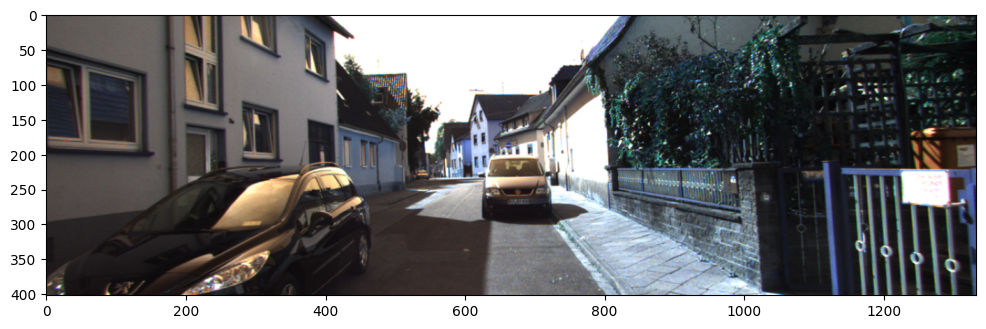

In [60]:
# show image
batch = next(iter(dataloader))
img = batch[0]['image']
img = np.ascontiguousarray(img.permute(1, 2, 0), dtype=np.uint8)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
plt.imshow(img)

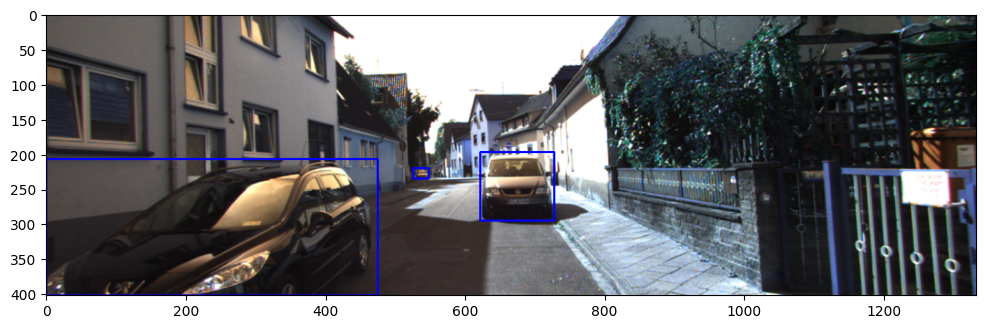

In [61]:
import torch

gt_boxes = batch[0]['instances'].gt_boxes.tensor.to(torch.int64).numpy()

import cv2

for gt_box in gt_boxes:
    img = cv2.rectangle(img, (gt_box[0], gt_box[1]),
                        (gt_box[2], gt_box[3]),
                        (0, 0, 255), 2, 1)

fig = plt.figure(figsize=(12, 12))
plt.imshow(img)

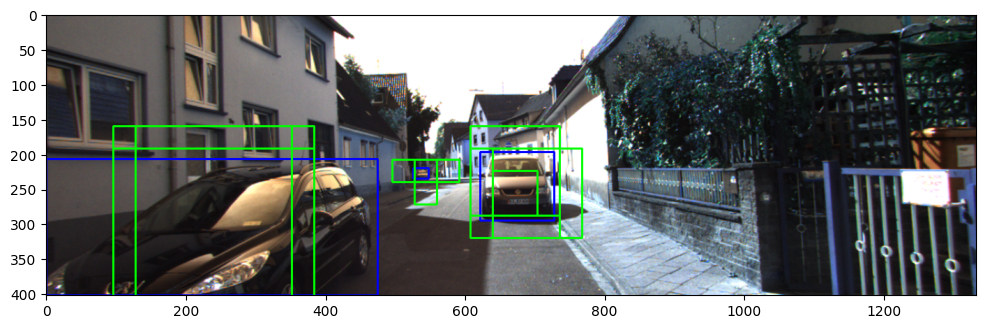

In [69]:
batch_size = 1
h, w = 13, 42

features = torch.rand((batch_size, channels, h, w))
features = [features]

anchors = model.anchor_generator(features)
pred_anchor_deltas = [torch.zeros((batch_size, h * w * 5, 4))]

indices = model.get_ground_truth(anchors, pred_anchor_deltas, [batch[0]['instances']])

nearest_boxes = anchors[0][0].tensor[indices[0][0]].to(torch.int64)

for box in nearest_boxes:
    box = box.numpy()
    img = cv2.rectangle(img, (box[0], box[1]),
                        (box[2], box[3]),
                        (0, 255, 0), 2, 1)

fig = plt.figure(figsize=(12, 12))
plt.imshow(img)

# Predict

In [22]:
from detectron2.checkpoint import DetectionCheckpointer

DetectionCheckpointer(model).load(cfg.train.init_checkpoint)

[03/15 10:59:38 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-50.pkl ...
[03/15 10:59:38 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[03/15 10:59:39 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone - Total num: 54


Some model parameters or buffers are not found in the checkpoint:
anchor_generator.cell_anchors.0
decoder.bbox_pred.{bias, weight}
decoder.bbox_subnet.0.{bias, weight}
decoder.bbox_subnet.1.{bias, running_mean, running_var, weight}
decoder.bbox_subnet.10.{bias, running_mean, running_var, weight}
decoder.bbox_subnet.3.{bias, weight}
decoder.bbox_subnet.4.{bias, running_mean, running_var, weight}
decoder.bbox_subnet.6.{bias, weight}
decoder.bbox_subnet.7.{bias, running_mean, running_var, weight}
decoder.bbox_subnet.9.{bias, weight}
decoder.cls_score.{bias, weight}
decoder.cls_subnet.0.{bias, weight}
decoder.cls_subnet.1.{bias, running_mean, running_var, weight}
decoder.cls_subnet.3.{bias, weight}
decoder.cls_subnet.4.{bias, running_mean, running_var, weight}
decoder.object_pred.{bias, weight}
encoder.dilated_encoder_blocks.0.conv1.0.{bias, weight}
encoder.dilated_encoder_blocks.0.conv1.1.{bias, running_mean, running_var, weight}
encoder.dilated_encoder_blocks.0.conv2.0.{bias, weight}
enc

{'__author__': 'Caffe2', 'matching_heuristics': True}

In [23]:
model.training = False
output = model(batch)

In [24]:
output

[{'instances': Instances(num_instances=8, image_height=375, image_width=1242, fields=[pred_boxes: Boxes(tensor([[ 515.7699,  124.8779,  563.8920,  258.3571],
          [ 379.2601,   21.8986,  907.1531,  336.3104],
          [ 479.1726,   56.6568,  594.1837,  361.2537],
          [  90.7595,  183.7474,  473.9928,  353.5661],
          [ 379.2601,   21.8986,  907.1531,  336.3104],
          [ 553.8643,  237.3009,  603.2058,  375.0000],
          [  97.4566,  103.0675, 1154.7925,  375.0000],
          [ 383.1249,  226.3171,  391.8783,  279.0017]],
         grad_fn=<IndexBackward0>)), scores: tensor([0.0744, 0.0677, 0.0660, 0.0652, 0.0613, 0.0581, 0.0545, 0.0528],
         grad_fn=<IndexBackward0>), pred_classes: tensor([51, 18, 60, 30, 23, 60, 26, 54])])}]

In [74]:
DetectionCheckpointer(model).load('./output/model_0002599.pth')

[03/15 11:31:45 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_0002599.pth ...
[03/15 11:31:45 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_0002599.pth ...
[03/15 11:31:45 fvcore.common.checkpoint]: [Checkpointer] Loading from ./output/model_0002599.pth ...


{'trainer': {'iteration': 2599,
  'hooks': {'LRScheduler': {'base_lrs': [0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
     0.00033400000000000004,
    

In [75]:
model.training = False
output = model(batch)

In [76]:
output

[{'instances': Instances(num_instances=8, image_height=375, image_width=1242, fields=[pred_boxes: Boxes(tensor([[ 655.7921,  208.9547,  656.0879,  208.9558],
          [ 655.9285,  179.1042,  655.9515,  179.1047],
          [   0.0000,    0.0000, 1242.0000,  375.0000],
          [   0.0000,    0.0000, 1242.0000,  375.0000],
          [   0.0000,    0.0000, 1242.0000,  375.0000],
          [   0.0000,  195.1221,  423.9035,  375.0000],
          [   0.0000,  162.6272,  427.1421,  374.6862],
          [   0.0000,   26.2675, 1242.0000,  375.0000]],
         grad_fn=<IndexBackward0>)), scores: tensor([0.9951, 0.9622, 0.9504, 0.9370, 0.9303, 0.8031, 0.7980, 0.1376],
         grad_fn=<IndexBackward0>), pred_classes: tensor([7, 7, 7, 7, 1, 7, 7, 1])])}]

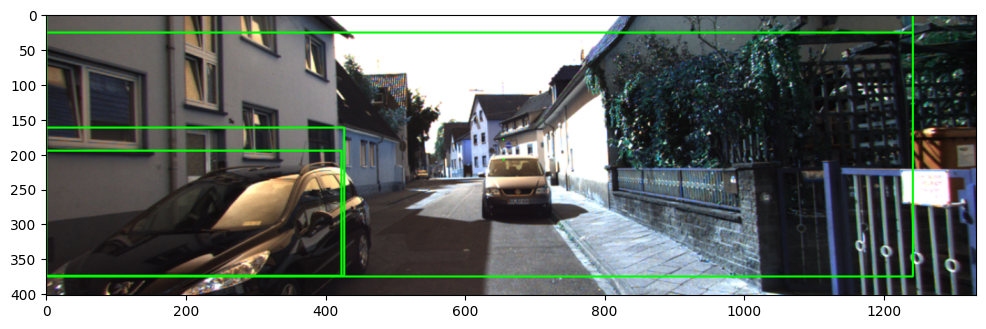

In [78]:
boxes = output[0]['instances'].pred_boxes.tensor.detach().to(torch.int64).numpy()

img = batch[0]['image']
img = np.ascontiguousarray(img.permute(1, 2, 0), dtype=np.uint8)

for box in boxes:
    img = cv2.rectangle(img, (box[0], box[1]),
                        (box[2], box[3]),
                        (0, 255, 0), 2, 1)

fig = plt.figure(figsize=(12, 12))
plt.imshow(img)